# Stochastic Diversity Evaluation for BCQ

Because BCQ is a generative model, it can generate different actions for the same state. This example code explores its capabilities of producing diverse, meaningful results.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


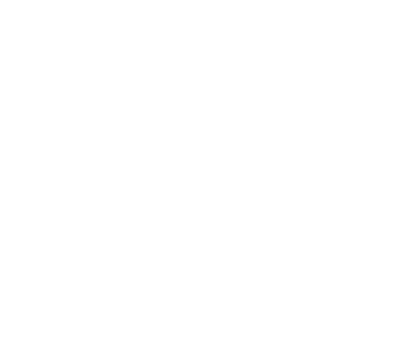

In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.spatial import distance
import pickle
import json
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')
plt.axis('off')

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

models = load_file("../../utils/models.py", "models")
plot = load_file("../../utils/plot.py", "plot")

cuda = torch.device('cuda')
frame_size = 10
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
# https://drive.google.com/open?id=1pPf-7AmUVceVfgfmKEJ6ireEDKEJHw-7
f = h5py.File("../../data/static_ml20m.hdf5", "r")
# https://drive.google.com/open?id=1xjVI4uVQGsQ7tjOJ3594ZXmAEC_6yX0e
meta = json.load(open('../../data/metadata.json'))
print()

In [3]:
bcq_actor = models.BCQ_Actor(1290, 128, 256).to(cuda)
bcq_vae = models.BCQ_VAE(1290, 128, 512).to(cuda)
bcq_actor.load_state_dict(torch.load('../../models/BCQ/bcq_policy.pt'))
bcq_vae.load_state_dict(torch.load('../../models/BCQ/bcq_vae.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
batch_size = 5000
n_batches = (f['done'].shape[0] // batch_size) - 1
test_batch = [f[key][n_batches*batch_size:(n_batches+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]


movies, ratings, done = test_batch
movies, ratings, done = [torch.tensor(i.astype('float32')) for i in [movies, ratings, done]]
movies_tensor = torch.stack([torch.
                             stack([movie_ref[int(i)] for i in ts]) for ts in movies])
    
state = torch.cat([movies_tensor[:, :-1, :].view(batch_size, -1),
                       ratings[:, :-1]], 1).to(cuda)

In [5]:
def rank(gen_action, metric):
    scores = []
    for i in movie_ref.keys():
        scores.append([i, metric(movie_ref[i], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    dist = [i[1] for i in scores]

    return ids, dist

import faiss
# test indexes
indexL2 = faiss.IndexFlatL2(128)
indexIP = faiss.IndexFlatIP(128)
indexCOS = faiss.IndexFlatIP(128)

mov_mat  = np.stack(movie_ref.values()).astype('float32')
indexL2.add(mov_mat)
indexIP.add(mov_mat)
indexCOS.add(normalize(mov_mat, axis=1, norm='l2'))


def query(index, action, k=20):
    D, I = index.search(action, k)
    return D, I

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [6]:
# more than 5 actions don't work, the graphic looks ugly
# though you can change top k ranking
state = torch.repeat_interleave(state[0].unsqueeze(0), 5, dim=0)
sampled_actions = bcq_vae.decode(state)
perturbed_actions= bcq_actor(state, sampled_actions)
bcq_action = perturbed_actions

### Euclidean and cosine distances between generated actions for the same state

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


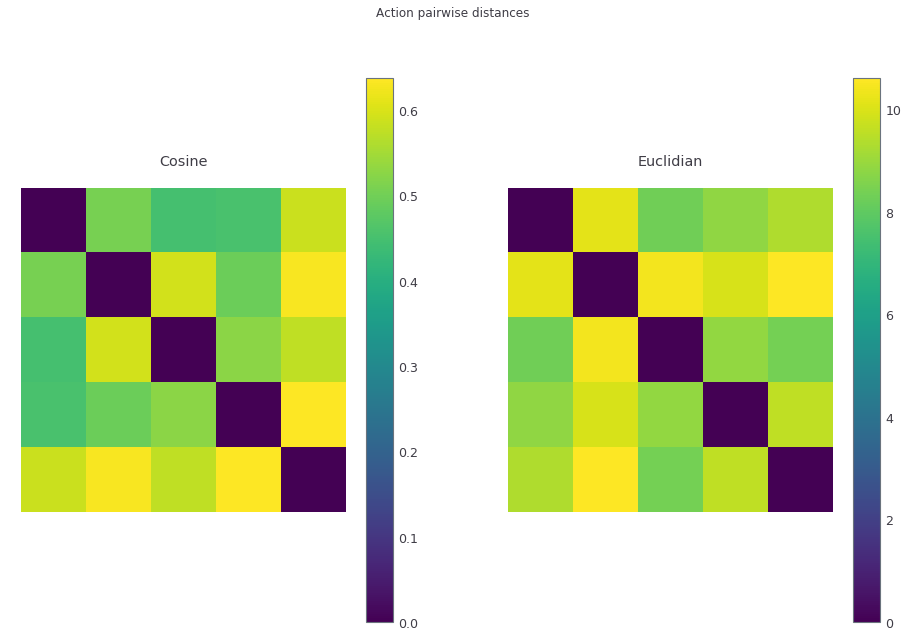

In [7]:
plot.embed_show(bcq_action)

## PyUpSet
### bokeh version in the next section

In [8]:
# you will need to build it yourself:
# git clone github.com/pedromiravaz/py-upset
# cd py-upset
# python setup.py install
# note pip install pyupset or cloning ImSoErgodic repo DOES NOT WORK

import pyupset as pyu

In [9]:
bcq_action = bcq_action.detach().cpu().numpy()

In [10]:
D, I = query(indexL2, bcq_action, 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})

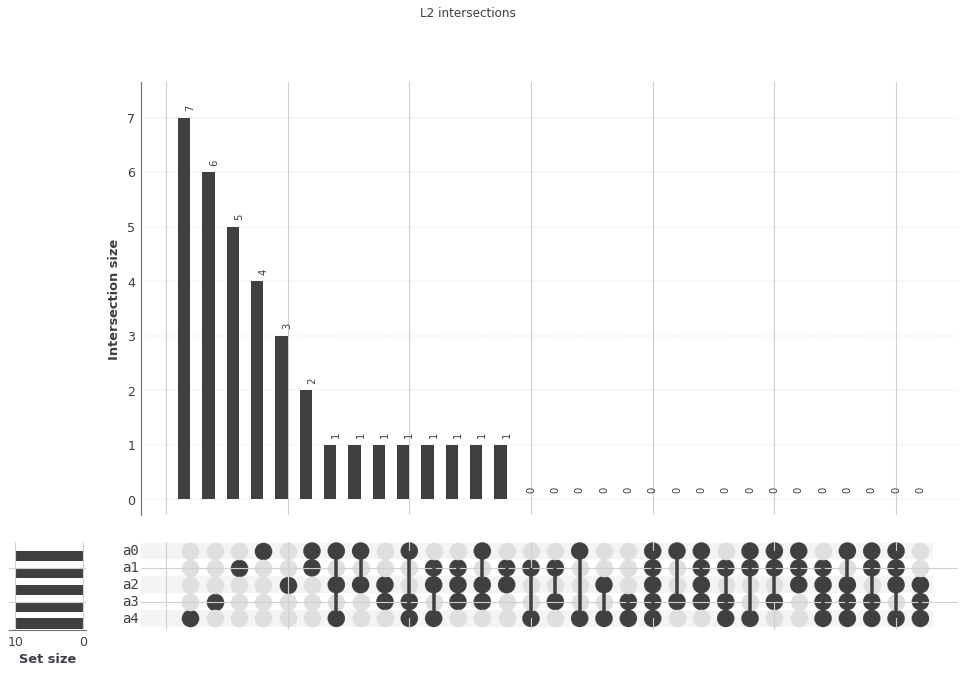

In [11]:
import warnings
warnings.filterwarnings("ignore")
pyu.plot(cat)
plt.suptitle('L2 intersections')
print()

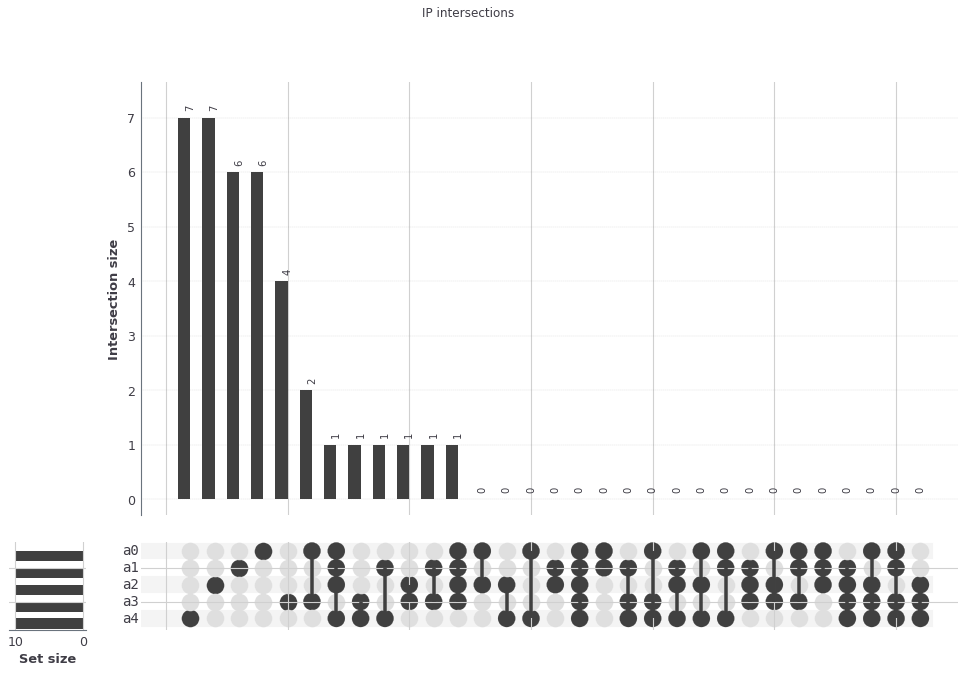

In [12]:
D, I = query(indexIP, bcq_action, 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})
pyu.plot(cat)
plt.suptitle('IP intersections')
print()

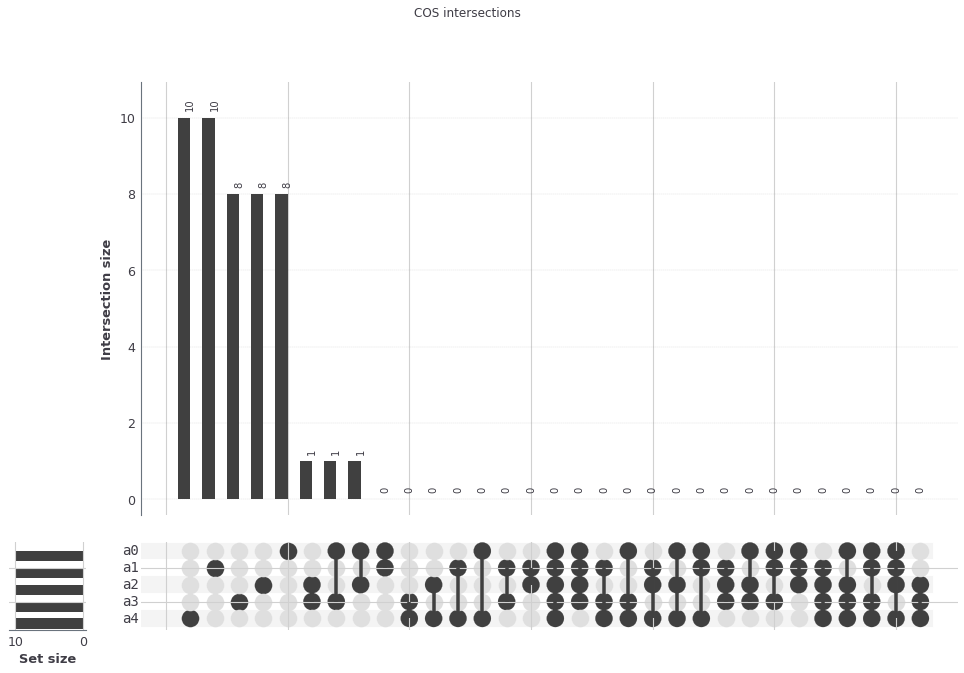

In [13]:
D, I = query(indexCOS, normalize(bcq_action, axis=1, norm='l2'), 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})
pyu.plot(cat)
plt.suptitle('COS intersections')
print()

## Distance Matrices

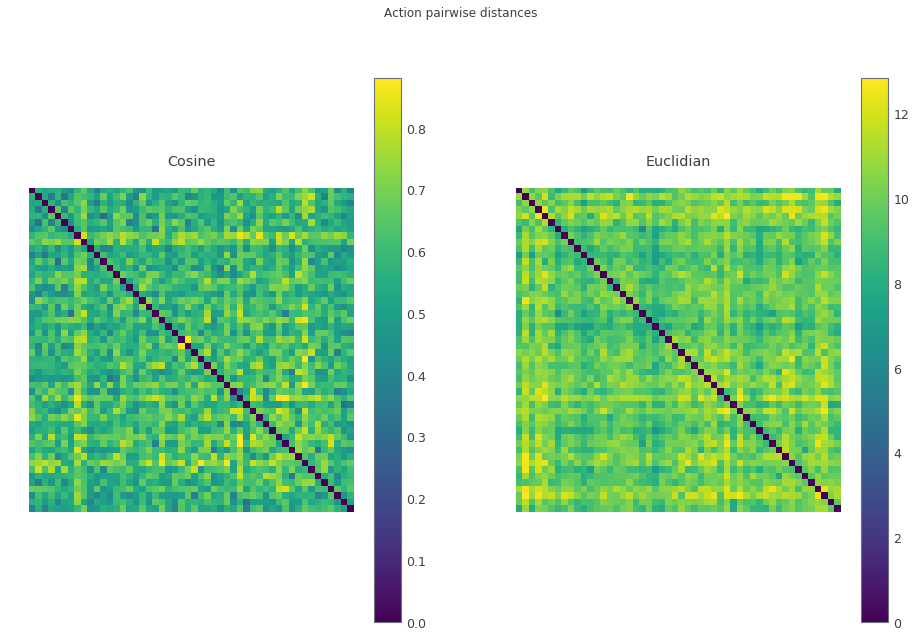

In [14]:
state = torch.repeat_interleave(state[0].unsqueeze(0), 50, dim=0)
sampled_actions = bcq_vae.decode(state)
perturbed_actions= bcq_actor(state, sampled_actions)
bcq_action = perturbed_actions
plot.embed_show(bcq_action)

cosine dist is pretty small

# Holoviews Chord diagram

In [21]:
# can someone do this please?